<a href="https://colab.research.google.com/github/gregor-posadas/Gregor-Projects/blob/main/Globally_Shared_Parameter_Based_Node_Diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Globally Shared Parameters**

Upload data files for the WWTP unit processes in sequence.
Enter the full path to the next process file (e.g., Influent): /content/Influent Parameters.csv
What is the name of this process? (e.g., Influent): Inf
Do you want to add another process file? (yes/no): yes
Enter the full path to the next process file (e.g., Influent): /content/Oxidation Ditch Effluent Parameters.xlsx
What is the name of this process? (e.g., Influent): ODE
Do you want to add another process file? (yes/no): no
Reading file: /content/Influent Parameters.csv
Applying Z-Score Method to filter outliers...
Finished processing file: /content/Influent Parameters.csv
Reading file: /content/Oxidation Ditch Effluent Parameters.xlsx
Applying Z-Score Method to filter outliers...
Finished processing file: /content/Oxidation Ditch Effluent Parameters.xlsx
Merged DataFrame before heatmap generation:
    phosphorus_Inf  total nitrogen_Inf  tkn_Inf  temperature_Inf  nitrite_Inf  \
0            14.15              135.00   134.00 

Globally shared parameters across all node pairs: {'phosphorus', 'ammonia', 'ph', 'temperature'}
Generating Globally Shared Network Diagram...
Processing connection: Inf → ODE
Checking parameter: phosphorus (phosphorus_Inf ↔ phosphorus_ODE)
Adding edge for phosphorus_Inf ↔ phosphorus_ODE (r=0.4134876668223626)
Checking parameter: ammonia (ammonia_Inf ↔ ammonia_ODE)
Adding edge for ammonia_Inf ↔ ammonia_ODE (r=0.46108712742749264)
Checking parameter: ph (ph_Inf ↔ ph_ODE)
Adding edge for ph_Inf ↔ ph_ODE (r=-0.3911307490060631)
Checking parameter: temperature (temperature_Inf ↔ temperature_ODE)
Adding edge for temperature_Inf ↔ temperature_ODE (r=0.8818772526225805)


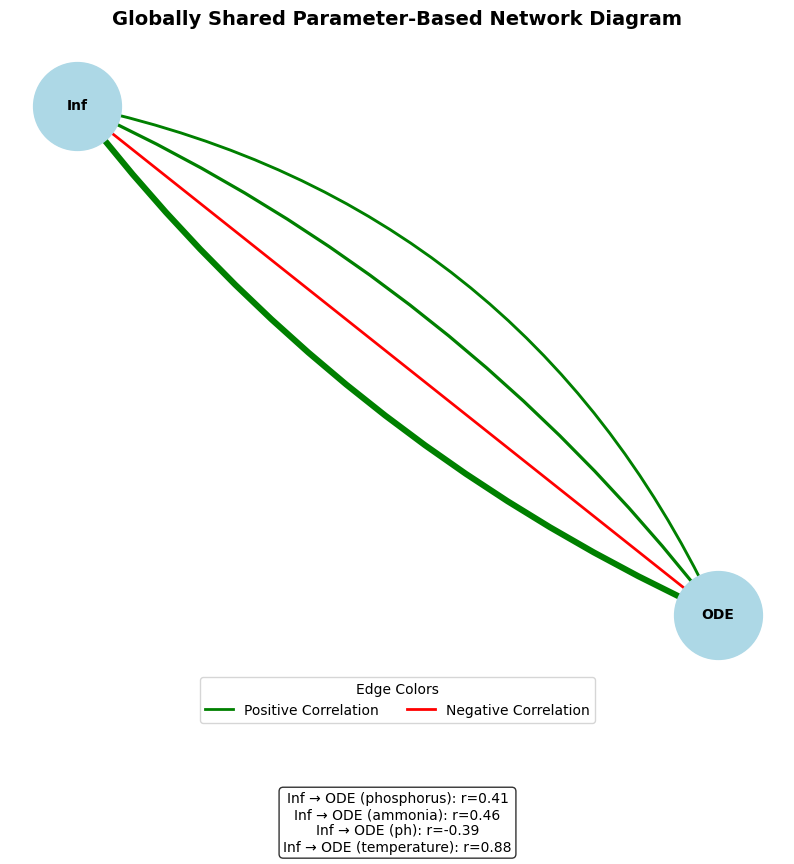

Generating Locally Shared Network Diagram...
Processing connection: Inf → ODE
Checking parameter: phosphorus (phosphorus_Inf ↔ phosphorus_ODE)
Adding edge for phosphorus_Inf ↔ phosphorus_ODE (r=0.4134876668223626)
Checking parameter: temperature (temperature_Inf ↔ temperature_ODE)
Adding edge for temperature_Inf ↔ temperature_ODE (r=0.8818772526225805)
Checking parameter: ph (ph_Inf ↔ ph_ODE)
Adding edge for ph_Inf ↔ ph_ODE (r=-0.3911307490060631)
Checking parameter: ammonia (ammonia_Inf ↔ ammonia_ODE)
Adding edge for ammonia_Inf ↔ ammonia_ODE (r=0.46108712742749264)


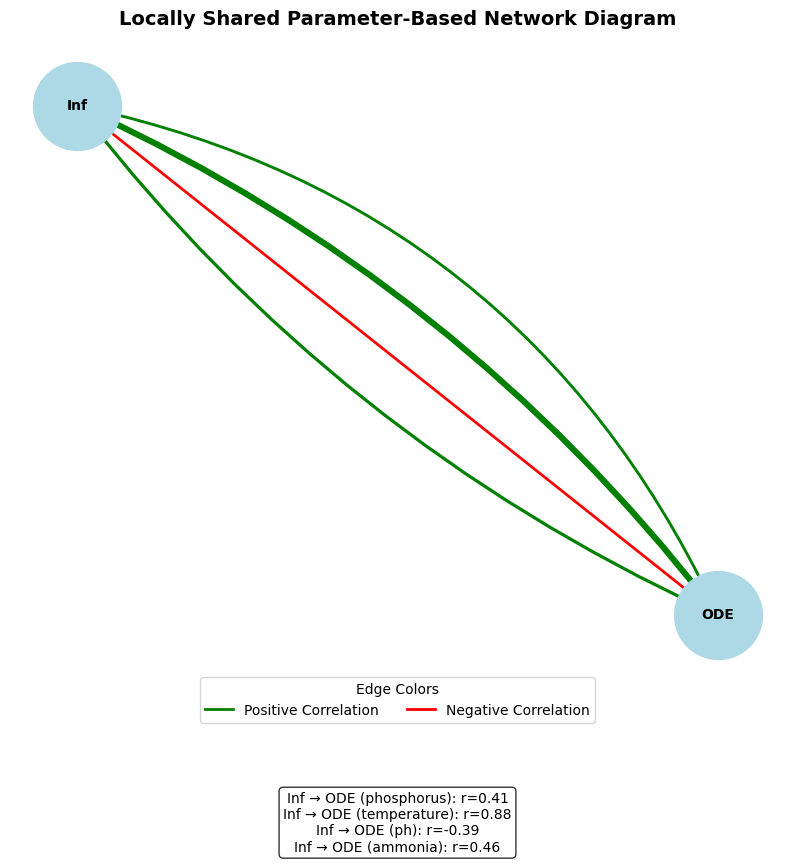

In [56]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib import colormaps

def bootstrap_correlations(df, n_iterations=500, method='pearson'):
    correlations = []
    for i in range(n_iterations):
        df_resampled = resample(df)
        corr_matrix = df_resampled.corr(method=method)
        correlations.append(corr_matrix)
    median_corr = pd.concat(correlations).groupby(level=0).median()
    return median_corr

def calculate_p_values(df, method='pearson'):
    p_values = pd.DataFrame(np.ones((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    for col1, col2 in itertools.combinations(df.columns, 2):
        _, p_val = stats.pearsonr(df[col1], df[col2])
        p_values.at[col1, col2] = p_val
        p_values.at[col2, col1] = p_val
    return p_values

def correct_p_values(p_values):
    _, corrected, _, _ = multipletests(p_values.values.flatten(), alpha=0.05, method='fdr_bh')
    corrected_p = pd.DataFrame(corrected.reshape(p_values.shape), index=p_values.index, columns=p_values.columns)
    return corrected_p

# Helper function to identify shared parameters
def find_common_parameters(dataframes):
    """
    Identify parameters (columns) that are common across multiple DataFrames.
    """
    if not dataframes:
        return []

    # Start with all columns from the first DataFrame
    common_columns = set(dataframes[0].columns)

    # Intersect with columns from the remaining DataFrames
    for df in dataframes[1:]:
        common_columns &= set(df.columns)

    # Exclude the 'date' column
    common_columns.discard('date')

    return list(common_columns)

# Helper function to remove outliers using Z-score
def remove_outliers_zscore(df, threshold=3):
    """
    Remove outliers from a DataFrame using the Z-score method.
    """
    print("Applying Z-Score Method to filter outliers...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy="omit"))
    mask = (z_scores < threshold).all(axis=1)
    return df[mask]

# Helper function to validate correlations
def validate_correlation_matrix(df, n_iterations=500, alpha=0.05):
    """
    Validate correlations using bootstrapping and p-value correction.
    Returns a filtered correlation matrix with only significant values.
    """
    print("Bootstrapping correlation matrices...")

    # Ensure all columns are numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna(axis=1, how='all')  # Drop columns that are entirely non-numeric or NaN

    pearson_corr = bootstrap_correlations(df, n_iterations=n_iterations, method='pearson')
    spearman_corr = bootstrap_correlations(df, n_iterations=n_iterations, method='spearman')
    kendall_corr = bootstrap_correlations(df, n_iterations=n_iterations, method='kendall')

    avg_corr_matrix = (pearson_corr + spearman_corr + kendall_corr) / 3

    print("Calculating and correcting p-values...")
    p_values = calculate_p_values(df, method='pearson')
    corrected_p_values = correct_p_values(p_values)

    sig_mask = (corrected_p_values < alpha).astype(int)
    filtered_corr_matrix = avg_corr_matrix.where(sig_mask > 0).fillna(0)

    return filtered_corr_matrix

# Function to generate heatmap
def generate_heatmap(df, title, labels):
    """
    Generate a heatmap and return the filtered correlation matrix.
    """
    filtered_corr_matrix = validate_correlation_matrix(df)
    parameter_order = sorted(filtered_corr_matrix.index)
    filtered_corr_matrix = filtered_corr_matrix.loc[parameter_order, parameter_order]

    np.fill_diagonal(filtered_corr_matrix.values, 1)

    print("Generating heatmap...")
    fig = px.imshow(
        filtered_corr_matrix,
        text_auto=".2f",
        color_continuous_scale="RdBu",
        zmin=-1,
        zmax=1,
        labels={"x": labels[0], "y": labels[1], "color": "Correlation Coefficient"},
        title=title,
    )

    fig.update_layout(
        title=dict(font=dict(size=20), x=0.5),
        xaxis=dict(tickangle=45, title=None, tickfont=dict(size=12)),
        yaxis=dict(title=None, tickfont=dict(size=12)),
        autosize=False,
        width=1200,
        height=1000,
        margin=dict(l=100, r=100, t=100, b=100),
    )

    fig.show()
    return filtered_corr_matrix

# Function to generate network diagram
def generate_network_diagram(labels, correlation_matrices, parameters, globally_shared=True):
    """
    Generate a parameter-based network diagram.
    If globally_shared is True, only globally shared parameters are included.
    Otherwise, locally shared parameters are used.
    """
    G = nx.MultiGraph()
    diagram_type = "Globally Shared" if globally_shared else "Locally Shared"

    print(f"Generating {diagram_type} Network Diagram...")

    for i in range(len(labels) - 1):
        print(f"Processing connection: {labels[i]} → {labels[i + 1]}")

        # Retrieve the filtered correlation matrix for this pair
        filtered_corr_matrix = correlation_matrices[i]

        # Track added edges to avoid duplicates
        added_edges = set()

        for parameter in parameters[i] if not globally_shared else parameters:
            infl_param = f"{parameter}_{labels[i]}"
            ode_param = f"{parameter}_{labels[i + 1]}"
            print(f"Checking parameter: {parameter} ({infl_param} ↔ {ode_param})")

            if infl_param in filtered_corr_matrix.index and ode_param in filtered_corr_matrix.columns:
                corr_value = filtered_corr_matrix.loc[infl_param, ode_param]

                # Skip if correlation is zero or edge already added
                edge_key = (labels[i], labels[i + 1], parameter)
                if corr_value == 0 or edge_key in added_edges:
                    continue

                # Add edge
                print(f"Adding edge for {infl_param} ↔ {ode_param} (r={corr_value})")
                G.add_edge(
                    labels[i],
                    labels[i + 1],
                    parameter=parameter,
                    correlation=corr_value,
                    weight=abs(corr_value),
                )
                added_edges.add(edge_key)

    # Adjust layout
    pos = nx.spring_layout(G, k=0.01, seed=42)
    plt.figure(figsize=(10, 8))

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=4000, node_color="lightblue")
    formatted_labels = {label: label.replace("_", "\n") for label in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=formatted_labels, font_size=10, font_weight="bold")

    for (u, v, d), idx in zip(G.edges(data=True), range(len(G.edges()))):
        curvature = 0.5 * (idx - len(G.edges()) // 2) / len(G.edges())
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],
            connectionstyle=f"arc3,rad={curvature}",
            edge_color="green" if d["correlation"] > 0 else "red",
            width=d["weight"] * 5,
        )

    # Add a legend
    plt.legend(
        handles=[
            plt.Line2D([0], [0], color="green", lw=2, label="Positive Correlation"),
            plt.Line2D([0], [0], color="red", lw=2, label="Negative Correlation"),
        ],
        loc="lower center",
        bbox_to_anchor=(0.5, -0.1),
        ncol=2,
        title="Edge Colors",
    )

    # Add a text box summarizing parameter details
    edge_details = "\n".join(
        [f"{u} → {v} ({d['parameter']}): r={d['correlation']:.2f}" for u, v, d in G.edges(data=True)]
    )
    ax = plt.gca()
    ax.text(
        0.5, -0.2, edge_details,
        fontsize=10, ha="center", va="top",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3", alpha=0.8),
        transform=ax.transAxes,
    )

    plt.title(f"{diagram_type} Parameter-Based Network Diagram", fontsize=14, pad=20, weight="bold")
    plt.axis("off")
    plt.show()

# Sequential file upload
def upload_files_sequentially():
    process_files = []
    process_labels = []

    while True:
        process_file = input("Enter the full path to the next process file (e.g., Influent): ")
        process_label = input(f"What is the name of this process? (e.g., Influent): ")

        process_files.append(process_file)
        process_labels.append(process_label)

        add_another = input("Do you want to add another process file? (yes/no): ").strip().lower()
        if add_another != 'yes':
            break

    return process_files, process_labels

# Read and align datasets with Z-score filtering
def read_file(file_path):
    """
    Read an Excel or CSV file into a DataFrame and normalize column names, with Z-score filtering.
    """
    try:
        print(f"Reading file: {file_path}")
        if file_path.endswith(".xlsx") or file_path.endswith(".xls"):
            df = pd.read_excel(file_path)
        elif file_path.endswith(".csv"):
            df = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported file format. Please use .xlsx, .xls, or .csv files.")

        df.columns = df.columns.str.lower().str.strip()
        if 'date' not in df.columns:
            raise KeyError(f"The file {file_path} does not contain a 'date' column.")
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=["date"])  # Drop rows with invalid dates
        df = remove_outliers_zscore(df)  # Apply Z-score filtering
        print(f"Finished processing file: {file_path}")
        return df
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        raise

# Main Function
if __name__ == "__main__":
    print("Upload data files for the WWTP unit processes in sequence.")
    process_files, process_labels = upload_files_sequentially()

    if len(process_files) < 2:
        print("Error: You need at least 2 files to generate diagrams.")
        exit()

    # Read data
    dataframes = [read_file(file) for file in process_files]

    # Common parameters
    common_params = find_common_parameters(dataframes)
    if not common_params:
        print("Error: No common parameters found.")
        exit()

    # Generate heatmaps and store correlation matrices
    correlation_matrices = []
    parameters_per_edge = []
    for i in range(len(dataframes) - 1):
        df1 = dataframes[i][['date'] + common_params]
        df2 = dataframes[i + 1][['date'] + common_params]
        merged_df = pd.merge(df1, df2, on="date", suffixes=(f"_{process_labels[i]}", f"_{process_labels[i + 1]}"))
        merged_df = merged_df.drop(columns=["date"], errors="ignore")

        # Handle invalid values
        merged_df = merged_df.replace([np.inf, -np.inf], np.nan)
        merged_df = merged_df.dropna()
        numeric_columns = merged_df.select_dtypes(include=[np.number]).columns
        merged_df = merged_df[numeric_columns]

        # Debugging outputs
        print("Merged DataFrame before heatmap generation:")
        print(merged_df)
        print("Checking for NaNs or Infs...")
        print(merged_df.isnull().sum())
        print(np.isfinite(merged_df).all())

        filtered_corr_matrix = generate_heatmap(
            merged_df,
            f"Correlation Coefficient Heatmap: {process_labels[i]} vs {process_labels[i + 1]}",
            (process_labels[i], process_labels[i + 1]),
        )
        correlation_matrices.append(filtered_corr_matrix)


        # Identify parameters contributing to the correlation
        shared_params = []
        for param in common_params:
            infl_param = f"{param}_{process_labels[i]}"
            ode_param = f"{param}_{process_labels[i + 1]}"
            if infl_param in filtered_corr_matrix.index and ode_param in filtered_corr_matrix.columns:
                if filtered_corr_matrix.loc[infl_param, ode_param] != 0:
                    shared_params.append(param)
        parameters_per_edge.append(shared_params)

    # Identify globally shared parameters
    globally_shared_parameters = set(parameters_per_edge[0])
    for params in parameters_per_edge[1:]:
        globally_shared_parameters &= set(params)

    print(f"Globally shared parameters across all node pairs: {globally_shared_parameters}")
    if not globally_shared_parameters:
        print("Error: No globally shared parameters found.")
        exit()

    # Generate network diagrams
    generate_network_diagram(process_labels, correlation_matrices, globally_shared_parameters, globally_shared=True)
    generate_network_diagram(process_labels, correlation_matrices, parameters_per_edge, globally_shared=False)



# **Correlation Bar Chart**

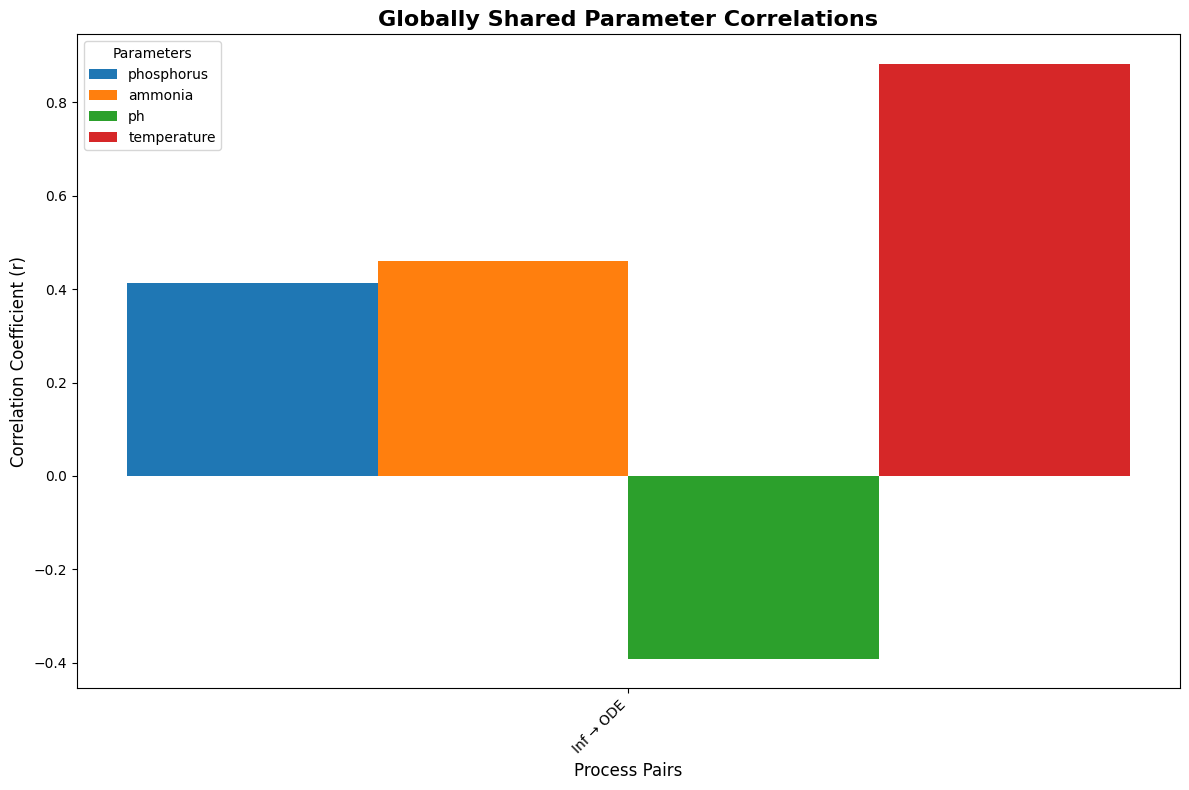

In [57]:
plot_gspd_correlations(process_labels, globally_shared_parameters, correlation_matrices)

# Generate a bar chart summarizing correlations for globally shared parameters
import matplotlib.pyplot as plt
import numpy as np

def plot_gspd_correlations(process_labels, globally_shared_parameters, correlation_matrices):
    """
    Generate a bar chart summarizing correlations for globally shared parameters across process pairs.

    Args:
        process_labels (list): List of process names (e.g., ["WAS", "Oxygenated RAS", ...]).
        globally_shared_parameters (set): Set of globally shared parameters.
        correlation_matrices (list): List of filtered correlation matrices for each process pair.
    """
    # Initialize data structure for correlations
    data = {param: [] for param in globally_shared_parameters}
    process_pairs = []

    # Collect correlation data for each process pair
    for i, matrix in enumerate(correlation_matrices):
        pair_label = f"{process_labels[i]} → {process_labels[i + 1]}"
        process_pairs.append(pair_label)

        for param in globally_shared_parameters:
            infl_param = f"{param}_{process_labels[i]}"
            ode_param = f"{param}_{process_labels[i + 1]}"

            if infl_param in matrix.index and ode_param in matrix.columns:
                corr_value = matrix.loc[infl_param, ode_param]
                data[param].append(corr_value)
            else:
                data[param].append(0)  # Fill missing correlations with 0

    # Plot bar chart
    bar_width = 0.15
    x = np.arange(len(process_pairs))

    plt.figure(figsize=(12, 8))
    for i, (param, correlations) in enumerate(data.items()):
        plt.bar(x + i * bar_width, correlations, bar_width, label=param)

    plt.xlabel("Process Pairs", fontsize=12)
    plt.ylabel("Correlation Coefficient (r)", fontsize=12)
    plt.title("Globally Shared Parameter Correlations", fontsize=16, weight="bold")
    plt.xticks(x + (len(globally_shared_parameters) - 1) * bar_width / 2, process_pairs, rotation=45, ha="right")
    plt.legend(title="Parameters")
    plt.tight_layout()
    plt.show()

# Example usage after running the GSPD code:
# plot_gspd_correlations(process_labels, globally_shared_parameters, correlation_matrices)


# **Targeted-Parameter Dictionary (NOT WORKING)**

In [44]:
from ipywidgets import Dropdown, Button, VBox, Output
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

# Initialize example variables (replace these with your actual data from the main code)
process_labels = []  # This will be dynamically updated
correlation_matrices = []  # Populate with your actual correlation matrices

# Function to initialize process labels
def initialize_process_labels(input_labels):
    global process_labels
    process_labels = [label.replace(" ", "_") for label in input_labels]
    process_dropdown.options = process_labels
    print("Process Labels Updated:", process_labels)

# Extend the analyze function to visualize

def analyze_specific_correlations(
    source_param,
    source_process,
    target_params,
    target_processes,
    correlation_matrices,
    process_labels,
):
    """
    Analyze correlations for a specific parameter from one process with
    parameters from other processes or the same process.

    Args:
        source_param (str): The parameter of interest (e.g., "DO").
        source_process (str): The source process (e.g., "Oxygenated RAS").
        target_params (list): List of target parameters to correlate with.
        target_processes (list): List of target processes to check correlations.
        correlation_matrices (list): List of filtered correlation matrices.
        process_labels (list): List of process names corresponding to the matrices.

    Returns:
        dict: A dictionary with correlation results.
    """
    results = {}

    # Find the index of the source process
    try:
        source_index = process_labels.index(source_process)
    except ValueError:
        raise ValueError(f"Source process '{source_process}' not found in process labels.")

    for i, target_process in enumerate(target_processes):
        if target_process not in process_labels:
            raise ValueError(f"Target process '{target_process}' not found in process labels.")

        target_index = process_labels.index(target_process)
        matrix_index = min(source_index, target_index)  # Determine which matrix to use

        # Determine the column names for source and target parameters
        correlations = {}
        for target_param in target_params:
            source_col = f"{source_param}_{source_process}"
            target_col = f"{target_param}_{target_process}"

            # Retrieve the correlation matrix
            matrix = correlation_matrices[matrix_index]
            if source_col in matrix.index and target_col in matrix.columns:
                corr_value = matrix.loc[source_col, target_col]
                correlations[target_param] = corr_value
            else:
                correlations[target_param] = None  # Correlation not found

        results[target_process] = correlations

    return results

def visualize_parameter_correlations(
    source_param, source_process, target_params, target_processes, correlation_matrices, process_labels
):
    """
    Visualize correlations for a specific parameter as a node diagram.

    Args:
        source_param (str): The parameter of interest (e.g., "DO").
        source_process (str): The source process (e.g., "Oxygenated RAS").
        target_params (list): List of target parameters to correlate with.
        target_processes (list): List of target processes to check correlations.
        correlation_matrices (list): List of filtered correlation matrices.
        process_labels (list): List of process names corresponding to the matrices.

    Returns:
        None: Displays a network diagram.
    """
    # Analyze correlations
    correlations = analyze_specific_correlations(
        source_param, source_process, target_params, target_processes, correlation_matrices, process_labels
    )

    # Create the network diagram
    G = nx.DiGraph()
    main_node = f"{source_param} ({source_process})"
    G.add_node(main_node)

    # Add nodes and edges based on correlations
    for process, param_corrs in correlations.items():
        for param, corr_value in param_corrs.items():
            if corr_value is not None:
                target_node = f"{param} ({process})"
                G.add_node(target_node)
                color = "green" if corr_value > 0 else "red"
                G.add_edge(main_node, target_node, weight=abs(corr_value), color=color, label=f"r={corr_value:.2f}")

    # Draw the network
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 8))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue")
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    # Draw edges
    edges = G.edges(data=True)
    colors = [edge[2]["color"] for edge in edges]
    weights = [edge[2]["weight"] * 2 for edge in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, width=weights, arrowstyle="-|>", arrowsize=20)

    # Add legend
    legend_elements = [
        Line2D([0], [0], color="green", lw=2, label="Positive Correlation"),
        Line2D([0], [0], color="red", lw=2, label="Negative Correlation"),
    ]
    plt.legend(handles=legend_elements, loc="lower left")

    plt.title(f"Correlation Diagram for {source_param} ({source_process})", fontsize=14)
    plt.axis("off")
    plt.show()

# Interactive Dropdown Widgets
process_dropdown = Dropdown(
    options=process_labels,
    description="Process:",
    disabled=False
)

parameter_dropdown = Dropdown(
    options=[],
    description="Parameter:",
    disabled=False
)

output = Output()

# Update parameter options based on selected process
def update_parameters(*args):
    selected_process = process_dropdown.value
    if selected_process:
        try:
            process_index = process_labels.index(selected_process)
            if process_index < len(correlation_matrices):
                matrix = correlation_matrices[process_index]
                print(f"Matrix for {selected_process}:\n{matrix}")
                params = [
                    col.split("_")[0]
                    for col in matrix.columns
                    if f"_{selected_process}" in col
                ]
                print(f"Extracted Parameters: {params}")
                parameter_dropdown.options = params
            else:
                print(f"No matrix found for process index {process_index}")
                parameter_dropdown.options = []
        except Exception as e:
            print(f"Error updating parameters: {e}")
            parameter_dropdown.options = []


# Button to trigger visualization
visualize_button = Button(description="Visualize Correlations")

def on_visualize_clicked(b):
    with output:
        output.clear_output()
        selected_process = process_dropdown.value
        selected_param = parameter_dropdown.value
        if selected_process and selected_param:
            visualize_parameter_correlations(
                source_param=selected_param,
                source_process=selected_process,
                target_params=parameter_dropdown.options,
                target_processes=process_labels,
                correlation_matrices=correlation_matrices,
                process_labels=process_labels,
            )

visualize_button.on_click(on_visualize_clicked)

# Display widgets and output
ui = VBox([process_dropdown, parameter_dropdown, visualize_button, output])
display(ui)

# **Data Processing Methodology Flowchart**

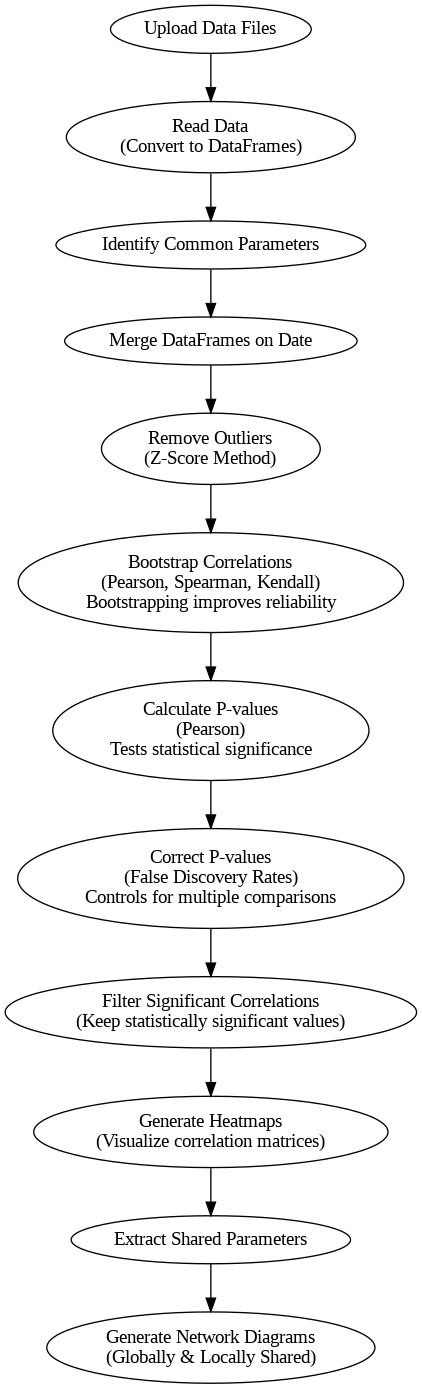

In [ ]:
from graphviz import Digraph
from IPython.display import Image, display

def create_flowchart():
    dot = Digraph(comment="Network Diagram Production Flowchart")

    # Nodes with subtitles in labels
    dot.node("A", "Upload Data Files")
    dot.node("B", "Read Data\n(Convert to DataFrames)")
    dot.node("C", "Identify Common Parameters")
    dot.node("D", "Merge DataFrames on Date")
    dot.node("E", "Remove Outliers\n(Z-Score Method)")
    dot.node("F", "Bootstrap Correlations\n(Pearson, Spearman, Kendall)\nBootstrapping improves reliability")
    dot.node("G", "Calculate P-values\n(Pearson)\nTests statistical significance")
    dot.node("H", "Correct P-values\n(False Discovery Rates)\nControls for multiple comparisons")
    dot.node("I", "Filter Significant Correlations\n(Keep statistically significant values)")
    dot.node("J", "Generate Heatmaps\n(Visualize correlation matrices)")
    dot.node("K", "Extract Shared Parameters")
    dot.node("L", "Generate Network Diagrams\n(Globally & Locally Shared)")

    # Edges
    dot.edge("A", "B")
    dot.edge("B", "C")
    dot.edge("C", "D")
    dot.edge("D", "E")
    dot.edge("E", "F")
    dot.edge("F", "G")
    dot.edge("G", "H")
    dot.edge("H", "I")
    dot.edge("I", "J")
    dot.edge("J", "K")
    dot.edge("K", "L")

    # Save to a temporary file and display
    filepath = "network_diagram_flowchart.png"
    dot.render(filepath, format="png", cleanup=True)
    display(Image(filepath + ".png"))

create_flowchart()
